Logistic Regression
====================

Let's set some setting for this Jupyter Notebook.

In [1]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Now, let's import the `LogisticRegression` model from the `pymc-learn` package.

In [2]:
import pmlearn
from pmlearn.linear_model import LogisticRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))

Running on pymc-learn v0.0.1.rc0


## Step 1: Prepare the data
Generate synthetic data.

In [3]:
num_pred = 2
num_samples = 700000
num_categories = 2

In [4]:
alphas = 5 * np.random.randn(num_categories) + 5 # mu_alpha = sigma_alpha = 5
betas = 10 * np.random.randn(num_categories, num_pred) + 10 # mu_beta = sigma_beta = 10

In [5]:
alphas

array([ 3.9764617 ,  7.39471669])

In [6]:
betas

array([[  4.80561285,   4.44269696],
       [ 29.65780573,  23.93405833]])

In [7]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [8]:
x_a = np.random.randn(num_samples, num_pred)
y_a = np.random.binomial(1, numpy_invlogit(alphas[0] + np.sum(betas[0] * x_a, 1)))
x_b = np.random.randn(num_samples, num_pred)
y_b = np.random.binomial(1, numpy_invlogit(alphas[1] + np.sum(betas[1] * x_b, 1)))

X = np.concatenate([x_a, x_b])
y = np.concatenate([y_a, y_b])
cats = np.concatenate([
    np.zeros(num_samples, dtype=np.int),
    np.ones(num_samples, dtype=np.int)
])

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, cats_train, cats_test = train_test_split(X, y, cats, test_size=0.3)

## Step 2: Instantiate a model

In [10]:
model = LogisticRegression()

## Step 3: Perform Inference

In [11]:
model.fit(X_train, y_train, cats_train, minibatch_size=2000, inference_args={'n': 60000})

Average Loss = 249.45: 100%|██████████| 60000/60000 [01:13<00:00, 814.48it/s]
Finished [100%]: Average Loss = 249.5


LogisticRegression()

## Step 4: Diagnose convergence

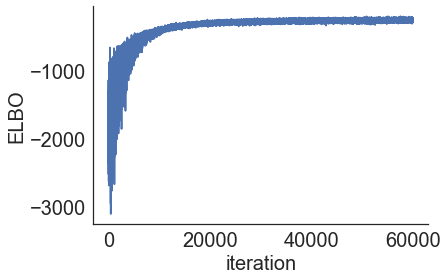

In [12]:
model.plot_elbo()

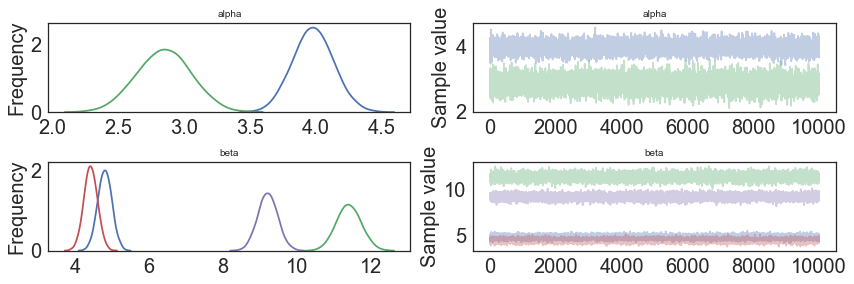

In [13]:
pm.traceplot(model.trace);

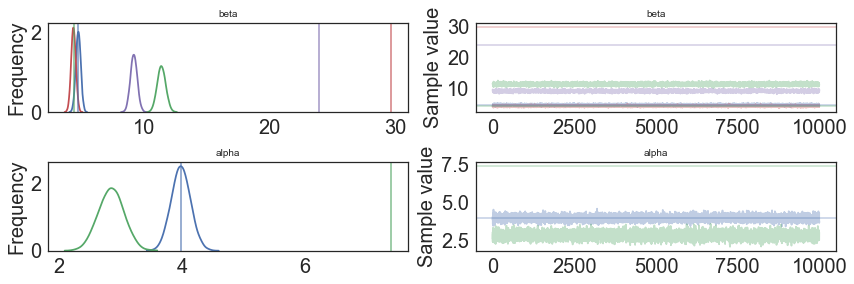

In [14]:
pm.traceplot(model.trace, lines = {"beta": betas, 
                                 "alpha": alphas}, 
             varnames=["beta", "alpha"]);

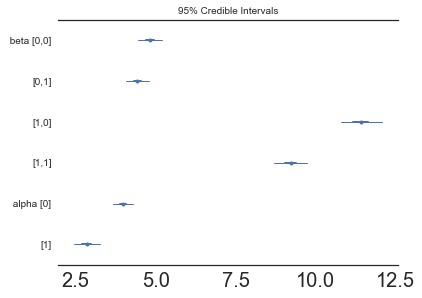

In [15]:
pm.forestplot(model.trace, varnames=["beta", "alpha"]);

## Step 5: Critize the model

In [16]:
pm.summary(model.trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,3.982634,0.153671,0.001556,3.678890,4.280575
alpha__1,2.850619,0.206359,0.001756,2.440148,3.242568
beta__0_0,4.809822,0.189382,0.001727,4.439762,5.188622
beta__0_1,4.427498,0.183183,0.001855,4.055033,4.776228
beta__1_0,11.413951,0.333251,0.003194,10.781074,12.081359
beta__1_1,9.218845,0.267730,0.002730,8.693964,9.745963


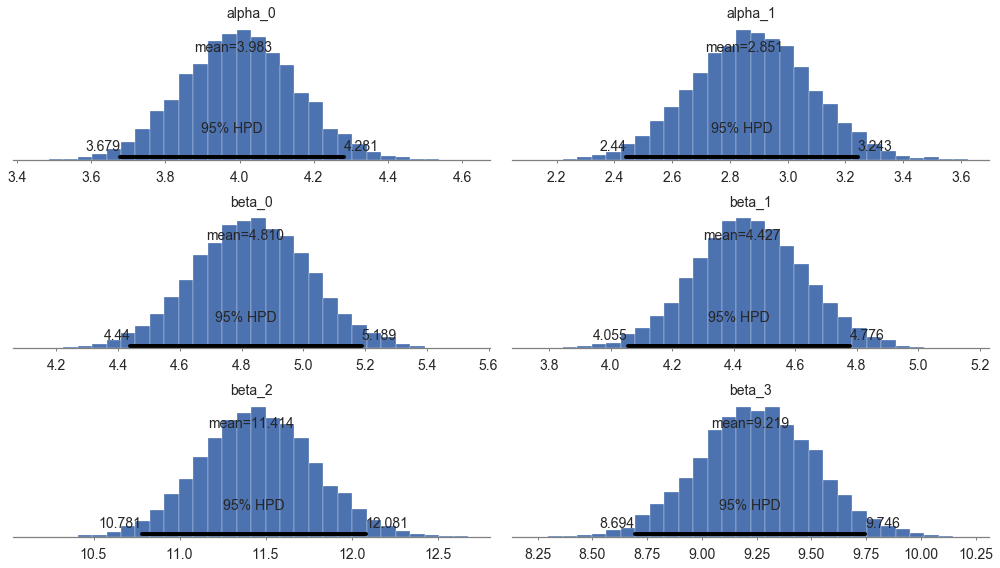

In [17]:
pm.plot_posterior(model.trace, figsize = [14, 8]);

In [18]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["beta", "alpha"],
               "Parameter-Learned (Mean Value)": [model.trace["beta"].mean(axis=0), 
                                model.trace["alpha"].mean(axis=0)],
               "True value": [betas, alphas]})

,Parameter,Parameter-Learned (Mean Value),True value
0,beta,"[[4.80982191646, 4.4274983607], [11.413950812,...","[[4.80561284943, 4.44269695653], [29.657805725..."
1,alpha,"[3.98263424275, 2.85061932727]","[3.97646170258, 7.39471669029]"


## Step 6: Use the model for prediction

In [19]:
y_probs = model.predict_proba(X_test, cats_test)

100%|██████████| 2000/2000 [01:24<00:00, 23.62it/s]


In [20]:
y_predicted = model.predict(X_test, cats_test)

100%|██████████| 2000/2000 [01:21<00:00, 24.65it/s]


In [21]:
model.score(X_test, y_test, cats_test)

100%|██████████| 2000/2000 [01:23<00:00, 23.97it/s]


0.9580642857142857

In [22]:
model.save('pickle_jar/logistic_model')

#### Use already trained model for prediction

In [23]:
model_new = LogisticRegression()

In [25]:
model_new.load('pickle_jar/logistic_model')

In [26]:
model_new.score(X_test, y_test, cats_test)

100%|██████████| 2000/2000 [01:23<00:00, 24.01it/s]


0.9581952380952381

## MCMC

In [ ]:
model2 = LogisticRegression()
model2.fit(X_train, y_train, cats_train, inference_type='nuts')

### Diagnose convergence

In [ ]:
pm.traceplot(model2.trace, lines = {"beta": betas, 
                                 "alpha": alphas}, 
             varnames=["beta", "alpha"]);

In [ ]:
pm.gelman_rubin(model2.trace)

In [ ]:
pm.energyplot(model2.trace);

### Criticize the model

In [ ]:
pm.summary(model2.trace)

In [ ]:
pm.plot_posterior(model2.trace, figsize = [14, 8]);

### Use the model for prediction

In [ ]:
y_predict2 = model2.predict(X_test)

In [ ]:
model2.score(X_test, y_test)

In [ ]:
model2.save('pickle_jar/logistic_model2')
model2_new = LogisticRegression()
model2_new.load('pickle_jar/logistic_model2')
model2_new.score(X_test, y_test, cats_test)